# ACFN Project Code

In [1]:
# !pip install wandb --quiet # Install WandB
# !pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

In [2]:
# !pip install torchsummaryX==1.1.0 wandb --quiet
# !pip install torchsummary

In [3]:
import torch

#from torchsummary import summary

import torch.nn.functional as F
import matplotlib.pyplot as plt

import os

import gc

from tqdm import tqdm

import numpy as np

import pandas as pd

from sklearn.metrics import accuracy_score

from sklearn import metrics as mt

from scipy.optimize import brentq

from scipy.interpolate import interp1d

import glob

import wandb

import matplotlib.pyplot as plt

#from pytorch_metric_learning import samplers

import csv


# Import necessary libraries

import pandas as pd

import numpy as np

import torch

import torch.nn as nn

import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import seaborn as sns



from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans, DBSCAN

from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.model_selection import train_test_split


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Device: ", DEVICE)


Device:  cuda


In [4]:
# from google.colab import drive # Link to your drive if you are not using Colab with GCP
# drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

In [5]:
# !pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
# !mkdir /root/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:
#     f.write('{"username":"yuyunfrancis","key":"1372ee73bffdf954300c05ce2a98bb3e"}')
#     # Put your kaggle username & key here

# !chmod 600 /root/.kaggle/kaggle.json

In [6]:
# # # Reminder: Make sure you have connected your kaggle API before running this block
# !mkdir '/content/data'

# !kaggle competitions download -c child-mind-institute-problematic-internet-use
# !unzip -qo 'child-mind-institute-problematic-internet-use.zip' -d '/content/data'

## Getting Parquet Data (Time Series)

In [47]:
# Step 1: Extract IDs from `parquet` files
def get_parquet_ids(data_directory):

    ids = set()
    for filename in os.listdir(data_directory):
        person_id = filename.split('=')[-1].split('.')[0]  # Extract ID from filename
        ids.add(person_id)
    return ids



## Getting Secondary data (Tabular data)

In [48]:
# Step 2: Load secondary dataset and filter based on available `parquet` IDs
def filter_secondary_data(secondary_dataset_path, parquet_ids):

    # Load secondary dataset
    secondary_df = pd.read_csv(secondary_dataset_path)

    # Filter rows to only those with IDs present in the parquet files
    filtered_df = secondary_df[secondary_df['id'].isin(parquet_ids)]

    # Create a dictionary mapping each ID to its `sii` value
    id_to_sii = pd.Series(filtered_df['sii'].values, index=filtered_df['id']).to_dict()
    return id_to_sii

gc.collect()

9814

In [49]:
# Define paths and extract IDs
data_directory = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet'  # Path to the directory with `parquet` files
secondary_dataset_path = '/kaggle/input/child-mind-institute-problematic-internet-use/train.csv'  # Path to the secondary dataset

# Get IDs from `parquet` files
parquet_ids = get_parquet_ids(data_directory)

# Filter the secondary dataset to match these IDs and create the label mapping
id_to_sii = filter_secondary_data(secondary_dataset_path, parquet_ids)
gc.collect()

0

In [50]:
secondary_view = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")

In [51]:
secondary_view.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
secondary_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")

In [53]:
secondary_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
def preprocess_secondary_data(secondary_df, id_to_sii):
    """
    Preprocess secondary dataset to match IDs in the primary parquet data and handle missing values.

    Args:
    - secondary_df (pd.DataFrame): The secondary dataset as a pandas DataFrame.
      This is the dataset that needs to be aligned and cleaned to match the primary dataset.
    - id_to_sii (dict): Dictionary with parquet IDs as keys and labels as values.
      This mapping ensures that the IDs in the secondary dataset align with the primary dataset.

    Returns:
    - processed_data (pd.DataFrame): Preprocessed secondary features aligned with primary dataset IDs.
      This dataframe contains the transformed features ready for model input.
    - labels (pd.Series): Labels corresponding to the filtered IDs in `processed_data`.
      These labels are derived from the secondary dataset and aligned with the IDs.
    """

    # Extract the IDs present in the primary parquet dataset
    parquet_ids = set(id_to_sii.keys())

    # Filter the secondary dataset to retain only rows with IDs matching those in the primary parquet data
    filtered_df = secondary_df[secondary_df['id'].isin(parquet_ids)].copy()

    # Handle missing labels by filling NaN values with -1
    labels = filtered_df['sii'].fillna(-1)

    # Separate the features from the dataset, excluding ID and label columns
    features = filtered_df.drop(columns=['id', 'sii'])

    # Identify categorical and numerical columns for appropriate preprocessing
    categorical_cols = features.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = features.select_dtypes(exclude=['object']).columns.tolist()

    # Define a pipeline for numerical features: imputes missing values with the mean and scales the data
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Define a pipeline for categorical features: imputes missing values with the most frequent value and encodes them
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute with most frequent for categorical
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode categorical features
    ])

    # Combine the numerical and categorical transformers using a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, numerical_cols),  # Apply num_transformer to numerical columns
            ('cat', cat_transformer, categorical_cols)  # Apply cat_transformer to categorical columns
        ]
    )

    # Fit and transform the features using the preprocessor
    features_processed = preprocessor.fit_transform(features)

    # Convert the processed features into a DataFrame, keeping the original index for alignment
    processed_data = pd.DataFrame(features_processed, index=filtered_df.index)

    # Add the ID column back to the processed dataset for reference
    processed_data['id'] = filtered_df['id'].values

    # Return the preprocessed features and the corresponding labels, resetting the index for labels
    return processed_data, labels.reset_index(drop=True)

# Preprocess the secondary data and extract the processed features and labels
process_secondary_data, labels = preprocess_secondary_data(secondary_df, id_to_sii)


In [55]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def augment_numerical_features(features, noise_level):
    """
    Add noise to numerical features for augmentation.
       
    Args:
    - features (pd.DataFrame): The numerical features to augment.
    - noise_level (float): The standard deviation of the noise to add.
    
    Returns:
    - augmented_features (pd.DataFrame): Augmented numerical features with the same shape.
    """
    noise = np.random.normal(loc=0, scale=noise_level, size=features.shape)
    return features + noise

def preprocess_secondary_data(secondary_df, id_to_sii, augment=False, noise_level=0.01):
    """
    Preprocess secondary dataset to match IDs in the primary parquet data, handle missing values, 
    and optionally augment the data by adding noise.
    
    Args:
    - secondary_df (pd.DataFrame): The secondary dataset as a pandas DataFrame.
    - id_to_sii (dict): Dictionary with parquet IDs as keys and labels as values.
    - augment (bool): Whether to apply data augmentation (noise injection) to the numerical features.
    - noise_level (float): The scale of noise to add for augmentation.
    
    Returns:
    - processed_data (pd.DataFrame): Preprocessed secondary features aligned with primary dataset IDs.
    - labels (pd.Series): Labels corresponding to the filtered IDs in `processed_data`.
    """
    # Filter dataset by IDs matching the primary data
    parquet_ids = set(id_to_sii.keys())
    filtered_df = secondary_df[secondary_df['id'].isin(parquet_ids)].copy()

    # Extract labels and features
    labels = filtered_df['sii'].fillna(-1)
    features = filtered_df.drop(columns=['id', 'sii'])

    # Identify categorical and numerical columns
    categorical_cols = features.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = features.select_dtypes(exclude=['object']).columns.tolist()

    # Pipelines for numerical and categorical feature processing
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Fill missing numerical values
        ('scaler', StandardScaler())  # Standardize numerical data
    ])
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Encode categorical data
    ])

    # Combine processing pipelines
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, numerical_cols),
            ('cat', cat_transformer, categorical_cols)
        ]
    )

    if augment:
        # Split and augment numerical features
        numerical_features = features[numerical_cols]
        augmented_numerical_features = augment_numerical_features(numerical_features, noise_level)

        # Combine augmented and original features
        augmented_features = pd.concat(
            [numerical_features, pd.DataFrame(augmented_numerical_features, columns=numerical_cols)],
            ignore_index=True
        )
        # Duplicate categorical features and IDs
        categorical_features = pd.concat([features[categorical_cols]] * 2, ignore_index=True)
        ids = pd.concat([filtered_df['id']] * 2, ignore_index=True)

        # Merge numerical and categorical features
        augmented_features = pd.concat([augmented_features, categorical_features], axis=1)
    else:
        augmented_features = features
        ids = filtered_df['id']

    # Apply preprocessing pipeline
    features_processed = preprocessor.fit_transform(augmented_features)

    # Extract transformed feature names
    cat_columns = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols)
    all_columns = numerical_cols + cat_columns.tolist()

    # Convert processed features to a DataFrame
    processed_data = pd.DataFrame(features_processed, columns=all_columns)
    processed_data['id'] = ids.values

    return processed_data, labels.reset_index(drop=True)


# Preprocess with augmentation
processed_data, labels = preprocess_secondary_data(secondary_df, id_to_sii, augment=True, noise_level=0.05)


In [56]:
class AccelerometerDataset(Dataset):
    def __init__(self, data_directory, sequence_length, features, label_dict, scaler=None, max_records=20000):
        """
        Initialize dataset by loading and preprocessing data from parquet files.
        Args:
        - data_directory (str): Directory containing the dataset.
        - sequence_length (int): Length of the sequences to generate.
        - features (list): List of feature column names.
        - label_dict (dict): Mapping of person IDs to labels.
        - scaler (object): Scaler object for feature normalization (default: StandardScaler).
        - max_records (int): Maximum records to load per file.
        """
        self.data_directory = os.path.join(data_directory, "series_train.parquet")
        self.sequence_length = sequence_length
        self.features = features
        self.label_dict = label_dict
        self.scaler = scaler if scaler else StandardScaler()
        self.max_records = max_records
        self.data = []  # Store processed data

        # Iterate over directories and preprocess files
        for directory in os.listdir(self.data_directory):
            if directory.startswith("id="):
                person_id = directory.split("=")[-1]
                label = self.label_dict.get(person_id, -1)  # Fetch label

                if label == -1:
                    continue  # Skip if label is missing

                file_path = os.path.join(self.data_directory, directory, "part-0.parquet")
                if os.path.exists(file_path):
                    df = pd.read_parquet(file_path)
                    df = df.head(self.max_records)  # Limit data
                    df = self.preprocess(df)  # Handle missing values and scale features
                    sequences = self.create_sequences(df[self.features].values)

                    for seq in sequences:
                        self.data.append((person_id, seq, label))  # Save person ID, sequence, and label

    def preprocess(self, df):
        """
        Preprocess dataframe by dropping rows with missing values and scaling features.
        Args:
        - df (pd.DataFrame): Input data.
        Returns:
        - pd.DataFrame: Preprocessed data.
        """
        df = df.dropna(subset=self.features)  # Drop rows with NaNs in features
        df[self.features] = self.scaler.fit_transform(df[self.features])  # Scale features
        return df

    def create_sequences(self, data):
        """
        Split data into overlapping sequences.
        Args:
        - data (np.array): Array of feature values.
        Returns:
        - list: List of sequences.
        """
        sequences = []
        for i in range(0, len(data) - self.sequence_length + 1, self.sequence_length):
            sequence = data[i:i + self.sequence_length]
            sequences.append(sequence)
        return sequences

    def __len__(self):
        """
        Return total number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Fetch a single sample by index.
        Args:
        - idx (int): Index of the sample.
        Returns:
        - tuple: (person ID, sequence, label).
        """
        person_id, sequence, label = self.data[idx]
        return person_id, torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [57]:
#Sanity check
data_directory = '/kaggle/input/child-mind-institute-problematic-internet-use'  # Root directory
sequence_length = 100
features = ['X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag', 'light', 'battery_voltage', 'time_of_day', 'weekday', 'quarter', 'relative_date_PCIAT']
label_dict = id_to_sii
batch_size = 8

# Initialize the dataset and dataloader
dataset = AccelerometerDataset(data_directory, sequence_length, features, label_dict, max_records=20000)
# dataloader = DataLoader(merged_dataset, batch_size=batch_size, shuffle=True)


In [58]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import os

def merge_datasets(secondary_data, secondary_labels, accelerometer_dataset, sequence_length):
    """
    Merge preprocessed secondary data with the data from AccelerometerDataset.

    Args:
    - secondary_data (pd.DataFrame): Processed secondary data.
    - secondary_labels (pd.Series): Labels for secondary data.
    - accelerometer_dataset (AccelerometerDataset): Instance of the accelerometer dataset.
    - sequence_length (int): The sequence length for tensor sequences.
    Returns:
    - merged_dataset (list): List of tuples containing (id, combined_features, label).
    """
    # Convert secondary data to tensors
    secondary_tensors = torch.tensor(secondary_data.drop(columns=['id']).values, dtype=torch.float32)
    secondary_ids = secondary_data['id'].tolist()
    secondary_label_tensors = torch.tensor(secondary_labels.values, dtype=torch.long)

    # Mapping from ID to secondary data tensor
    id_to_secondary = {id_: (sec_tensor, label) for id_, sec_tensor, label in zip(secondary_ids, secondary_tensors, secondary_label_tensors)}

    # Merged dataset
    merged_dataset = []

    for idx in range(len(accelerometer_dataset)):
        person_id, acc_sequence, acc_label = accelerometer_dataset[idx]

        # Check if secondary data is available for the same ID
        if person_id in id_to_secondary:
            sec_tensor, sec_label = id_to_secondary[person_id]

            # Concatenate accelerometer sequence with secondary features
            sec_tensor_padded = torch.nn.functional.pad(sec_tensor, (0, acc_sequence.shape[1] - sec_tensor.shape[0]))
            combined_features = torch.cat((acc_sequence, sec_tensor_padded.unsqueeze(0)), dim=0)

            # Confirm the labels match
            if acc_label != sec_label:
                raise ValueError(f"Label mismatch for ID {person_id}: {acc_label} != {sec_label}")

            merged_dataset.append((person_id, combined_features, acc_label))
        else:
            # Optionally handle missing secondary data (e.g., pad with zeros or skip)
            sec_tensor_padded = torch.zeros(1, acc_sequence.shape[1])
            combined_features = torch.cat((acc_sequence, sec_tensor_padded.unsqueeze(0)), dim=0)
            merged_dataset.append((person_id, combined_features, acc_label))

    return merged_dataset



# Preprocess secondary data
secondary_data, secondary_labels = preprocess_secondary_data(secondary_df, id_to_sii)

# Initialize AccelerometerDataset
accelerometer_dataset = AccelerometerDataset(data_directory, sequence_length, features, label_dict)

# Merge datasets
merged_dataset = merge_datasets(secondary_data, secondary_labels, accelerometer_dataset, sequence_length)

dataloader = DataLoader(merged_dataset, batch_size=batch_size, shuffle=True)

In [59]:

def cluster(secondary_df, id_to_sii, clustering_methods):
    """
    Preprocess secondary data and perform robust clustering on labeled data,
    extending it to unlabeled data.

    Args:
    - secondary_df (pd.DataFrame): The secondary dataset as a pandas DataFrame.
    - id_to_sii (dict): Dictionary with parquet IDs as keys and labels as values.
    - clustering_methods (list): List of clustering algorithms to evaluate.

    Returns:
    - best_model (object): Trained clustering model with the best performance.
    - combined_data (pd.DataFrame): Data with cluster labels assigned.
    - evaluation_results (dict): Metrics for all tested models.
    """
    # Preprocess the data
    processed_data, labels = preprocess_secondary_data(secondary_df, id_to_sii)
    
    # Align indices
    labels.index = processed_data.index
    
    # Separate labeled and unlabeled data
    labeled_data = processed_data.loc[labels != -1].drop(columns=['id'])
    unlabeled_data = processed_data.loc[labels == -1].drop(columns=['id'])
    true_labels = labels[labels != -1]
    
    # Train-test split for evaluation
    train_data, test_data, train_labels, test_labels = train_test_split(
        labeled_data, true_labels, test_size=0.2, random_state=42
    )
    
    evaluation_results = {}
    best_score = -np.inf
    best_model = None
    
    # Loop through clustering methods to find the best
    for method in clustering_methods:
        model_name = method['name']
        model = method['model']
        
        # Fit model to training data
        model.fit(train_data)
        if hasattr(model, 'predict'):
            predicted_train = model.predict(train_data)
            predicted_test = model.predict(test_data)
        else:
            predicted_train = model.labels_
            predicted_test = model.fit_predict(test_data)
        
        # Compute evaluation metrics
        if len(np.unique(predicted_test)) > 1:
            silhouette_avg = silhouette_score(test_data, predicted_test)
            davies_bouldin = davies_bouldin_score(test_data, predicted_test)
            calinski_harabasz = calinski_harabasz_score(test_data, predicted_test)
        else:
            silhouette_avg = -1  # Assign low score for single-cluster cases
            davies_bouldin = np.inf
            calinski_harabasz = 0
        
        ari_score = adjusted_rand_score(test_labels, predicted_test)
        
        evaluation_results[model_name] = {
            'Silhouette Score': silhouette_avg,
            'Davies-Bouldin Index': davies_bouldin,
            'Calinski-Harabasz Index': calinski_harabasz,
            'ARI Score': ari_score
        }

        # Select the best model based on Silhouette Score
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_model = model
    
    # Combine predicted labels for all labeled data
    if hasattr(best_model, 'predict'):
        full_labeled_predictions = best_model.predict(labeled_data)
    else:
        full_labeled_predictions = best_model.fit_predict(labeled_data)

    # Assign cluster labels to labeled data
    labeled_data['Cluster_Label'] = full_labeled_predictions

    # If there is any unlabeled data, predict its labels
    if not unlabeled_data.empty:
        if hasattr(best_model, 'predict'):
            predicted_classes = best_model.predict(unlabeled_data)
        else:
            predicted_classes = best_model.fit_predict(unlabeled_data)
        unlabeled_data['Cluster_Label'] = predicted_classes
        combined_data = pd.concat([labeled_data, unlabeled_data])
    else:
        combined_data = labeled_data
    
    return best_model, combined_data, evaluation_results


clustering_methods = [
    {'name': 'KMeans', 'model': KMeans(n_clusters=2, random_state=42, n_init=10)},
    {'name': 'DBSCAN', 'model': DBSCAN(eps=0.5, min_samples=2)},
    {'name': 'GaussianMixture', 'model': GaussianMixture(n_components=2, random_state=42)}
]


best_model, combined_data_with_labels, evaluation_results = cluster(
    secondary_df, id_to_sii, clustering_methods
)

# Output results
print("Best Model:", best_model)
print("Combined Data with Labels:")

print("Evaluation Results:")
for model_name, metrics in evaluation_results.items():
    print(f"{model_name}: {metrics}")


Best Model: GaussianMixture(n_components=2, random_state=42)
Combined Data with Labels:
Evaluation Results:
KMeans: {'Silhouette Score': 0.16200963104768673, 'Davies-Bouldin Index': 2.2917918948185596, 'Calinski-Harabasz Index': 34.60345676750707, 'ARI Score': 0.41569429896080257}
DBSCAN: {'Silhouette Score': -1, 'Davies-Bouldin Index': inf, 'Calinski-Harabasz Index': 0, 'ARI Score': 0.0}
GaussianMixture: {'Silhouette Score': 0.194992314426255, 'Davies-Bouldin Index': 2.629866649972684, 'Calinski-Harabasz Index': 19.970692814418797, 'ARI Score': 0.09103177410771128}


In [60]:
# class Encoder(nn.Module):
#     def __init__(self, input_size, hidden_size, latent_dim, num_layers=2):
#         super(Encoder, self).__init__()
#         self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_size * 2, latent_dim)  

#     def forward(self, x):
#         _, (hidden, _) = self.rnn(x)
#         hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
#         latent = self.fc(hidden)
#         return latent


In [61]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_dim, num_layers=2):
        """
        LSTM-based Encoder for sequence-to-sequence tasks.

        Args:
        - input_size (int): Dimension of the input features.
        - hidden_size (int): Number of units in the LSTM hidden layer.
        - latent_dim (int): Dimension of the latent vector.
        - num_layers (int): Number of LSTM layers (default: 2).
        """
        super(Encoder, self).__init__()
        self.rnn = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )  # Bi-directional LSTM
        self.fc = nn.Linear(hidden_size * 2, latent_dim)  # Fully connected layer for latent representation

    def forward(self, x):
        """
        Forward pass through the encoder.
        Args:
        - x (torch.Tensor): Input tensor of shape (batch_size, seq_length, input_size).
        Returns:
        - torch.Tensor: Latent vector of shape (batch_size, latent_dim).
        """
        _, (hidden, _) = self.rnn(x)  # Extract hidden states
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Concatenate final states from both directions
        latent = self.fc(hidden)  # Compute latent representation
        return latent


In [62]:
def get_encoded_values(encoder, dataloader, device):
    """
    Compute encoded latent representations for data in a DataLoader.

    Args:
    - encoder (nn.Module): The encoder model to generate latent representations.
    - dataloader (DataLoader): DataLoader providing batches of (person_ids, sequences, labels).
    - device (torch.device): Device to run computations (CPU or GPU).

    Returns:
    - averaged_encoded_values (dict): Dictionary mapping person_ids to averaged latent vectors.
    """
    encoder.eval()  # Set encoder to evaluation mode
    encoded_values = {}  # Store latent vectors for each person_id

    with torch.no_grad():  # Disable gradient computation for efficiency
        for person_ids, sequences, labels in dataloader:
            sequences = sequences.to(device)  # Move input to device
            latent = encoder(sequences)  # Get latent representations

            # Group latent vectors by person_id
            for i, latent_value in enumerate(latent):
                person_id = person_ids[i]
                if person_id not in encoded_values:
                    encoded_values[person_id] = []
                encoded_values[person_id].append(latent_value.cpu().numpy())  # Convert tensor to numpy array

    # Average latent vectors for each person_id
    averaged_encoded_values = {person_id: np.mean(values, axis=0) for person_id, values in encoded_values.items()}

    return averaged_encoded_values


In [63]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Select device (GPU/CPU)
input_size = len(features)  # Number of input features
hidden_size = 128  # Hidden layer size in the encoder
latent_dim = 64  # Dimension of latent representation
num_layers = 2  # Number of LSTM layers

encoder = Encoder(input_size, hidden_size, latent_dim, num_layers).to(device)  # Initialize encoder model

encoded_values = get_encoded_values(encoder, dataloader, device)  # Get latent representations

# Process secondary data
secondary_df = process_secondary_data.copy()  # Create a copy of secondary data
encoded_df = pd.DataFrame.from_dict(
    encoded_values, orient='index', columns=[f'latent_{i}' for i in range(latent_dim)]
)  # Convert latent vectors to DataFrame
encoded_df.reset_index(inplace=True)  # Reset index for DataFrame
encoded_df.rename(columns={'index': 'id'}, inplace=True)  # Rename index column to 'id'

combined_data = secondary_df.merge(encoded_df, on='id', how='inner')  # Merge with secondary data

# Add labels
id_to_label_series = pd.Series(id_to_sii)  # Convert label mapping to pandas Series
combined_data['label'] = combined_data['id'].map(id_to_label_series)  # Map labels to IDs


In [64]:
class CombinedDataset(Dataset):
    def __init__(self, combined_data):
        # Extract features and labels from the combined data
        self.features = combined_data.drop(columns=['id', 'label']).values.astype(np.float32)  # Remove 'id' and 'label'
        self.labels = combined_data['label'].values.astype(np.int64)  # Extract 'label' column as integer

    def __len__(self):
        return len(self.features)  # Return the number of samples

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)  # Convert features to tensor
        y = torch.tensor(self.labels[idx], dtype=torch.long)  # Convert labels to tensor
        return x, y  # Return feature-label pair


In [65]:
import torch.optim as optim

class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)  # Second fully connected layer
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU after first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU after second layer
        x = self.fc3(x)  # Final output
        return x


In [66]:
# Evaluation Metric: Quadratic Weighted Kappa
from sklearn.metrics import confusion_matrix

def quadratic_weighted_kappa(y_true, y_pred, N):
    """
    Compute the quadratic weighted kappa metric.

    Args:
        y_true (np.array): True labels.
        y_pred (np.array): Predicted labels.
        N (int): Number of distinct labels.

    Returns:
        float: Quadratic weighted kappa score.
    """
    # Calculate observed agreement (O) using the confusion matrix
    O = confusion_matrix(y_true, y_pred, labels=range(N))

    # Initialize weight matrix (W) for penalty calculations
    W = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            W[i, j] = ((i - j) ** 2) / ((N - 1) ** 2)  # Quadratic penalty for disagreements

    # Calculate expected agreement (E) from histograms of true and predicted labels
    true_hist = np.histogram(y_true, bins=np.arange(N+1))[0]
    pred_hist = np.histogram(y_pred, bins=np.arange(N+1))[0]
    E = np.outer(true_hist, pred_hist)  # Outer product of histograms
    E = E / E.sum() * O.sum()  # Normalize E to match O's scale

    # Compute kappa: 1 - (weighted disagreement / expected disagreement)
    numerator = np.sum(W * O)  # Weighted disagreement (observed)
    denominator = np.sum(W * E)  # Weighted disagreement (expected)
    kappa = 1 - numerator / denominator

    return kappa


In [67]:
#Prepare dataloader and model parameters
dataset = CombinedDataset(combined_data)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# Initialize model parameters
input_dim = combined_data.shape[1] - 2  
hidden_dim = 128
output_dim = len(combined_data['label'].unique())  # Number of unique labels

model = SimpleClassifier(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [68]:
# from torchsummary import summary

# Move model to the correct device
model = model.to(device)

# Get a batch from the train_loader
data_iter = iter(train_loader)
x_batch, y_batch = next(data_iter)

# Make sure the batch is on the correct device
x_batch = x_batch.to(device)




In [69]:
num_epochs = 10
best_qwk = 0.0
best_epoch = 0
train_losses = []
val_losses = []
accuracies = []
qwk_scores = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Get predictions and accumulate results for QWK
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate metrics
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    qwk_score = quadratic_weighted_kappa(np.array(all_labels), np.array(all_preds), N=output_dim)

    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    accuracies.append(val_accuracy)
    qwk_scores.append(qwk_score)

    # Save best model
    if qwk_score > best_qwk:
        best_qwk = qwk_score
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    print(f"QWK Score: {qwk_score:.4f}")
    print("-" * 50)

    # Early stopping (optional)
    # if epoch - best_epoch > 10:  # If no improvement for 10 epochs
    #     print("Early stopping triggered")
    #     break


Epoch 1/10
Train Loss: 0.7492, Train Accuracy: 75.50%
Val Loss: 0.3447, Val Accuracy: 94.00%
QWK Score: 0.9483
--------------------------------------------------
Epoch 2/10
Train Loss: 0.2656, Train Accuracy: 94.85%
Val Loss: 0.1998, Val Accuracy: 94.00%
QWK Score: 0.9471
--------------------------------------------------
Epoch 3/10
Train Loss: 0.1543, Train Accuracy: 96.61%
Val Loss: 0.1916, Val Accuracy: 93.50%
QWK Score: 0.9434
--------------------------------------------------
Epoch 4/10
Train Loss: 0.1006, Train Accuracy: 98.12%
Val Loss: 0.1651, Val Accuracy: 94.50%
QWK Score: 0.9522
--------------------------------------------------
Epoch 5/10
Train Loss: 0.0729, Train Accuracy: 98.24%
Val Loss: 0.1625, Val Accuracy: 92.50%
QWK Score: 0.9355
--------------------------------------------------
Epoch 6/10
Train Loss: 0.0578, Train Accuracy: 98.24%
Val Loss: 0.1760, Val Accuracy: 94.00%
QWK Score: 0.9479
--------------------------------------------------
Epoch 7/10
Train Loss: 0.040

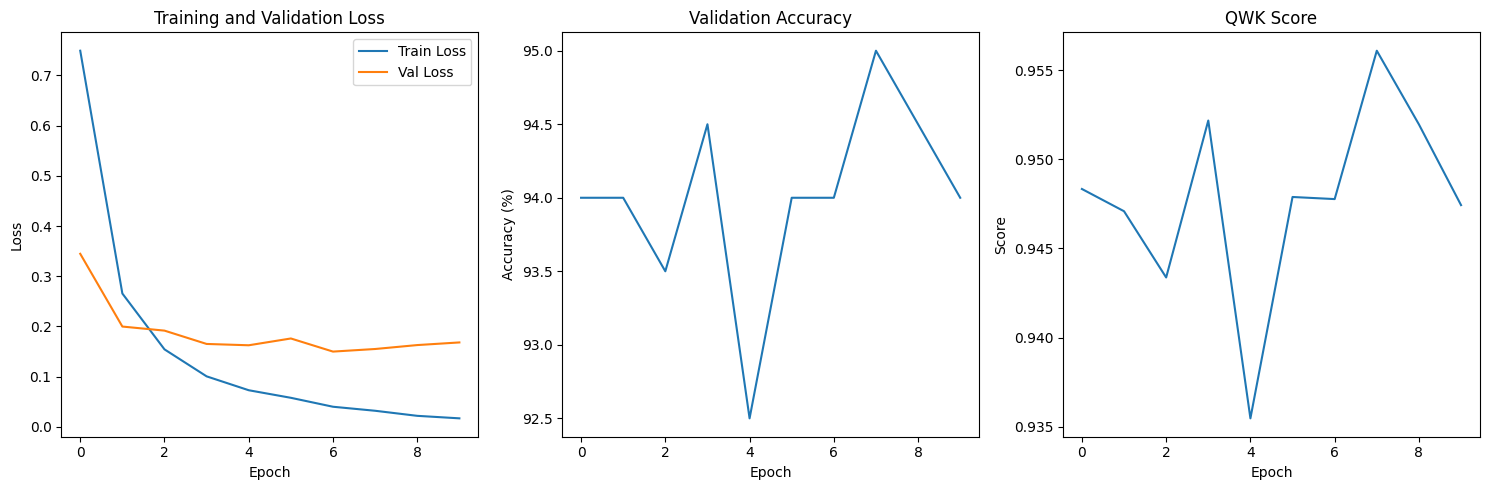

Best QWK Score: 0.9561 at epoch 8


In [70]:

# Plot training metrics
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

# QWK plot
plt.subplot(1, 3, 3)
plt.plot(qwk_scores)
plt.title('QWK Score')
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

print(f"Best QWK Score: {best_qwk:.4f} at epoch {best_epoch + 1}")

In [71]:
#Preparing data for testing

def preprocess_secondary_test_data(secondary_df):
    # Separate features and IDs
    features = secondary_df.drop(columns=['id'])
    ids = secondary_df['id']

    # Define preprocessing pipelines for numeric and categorical data
    categorical_cols = features.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = features.select_dtypes(exclude=['object']).columns.tolist()

    # Impute and scale numeric features
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Impute with mean for numeric
        ('scaler', StandardScaler())  # Standardize numeric features
    ])

    # Impute and encode categorical features
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute with most frequent for categorical
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, numerical_cols),
            ('cat', cat_transformer, categorical_cols)
        ]
    )

    # Fit and transform the features
    features_processed = preprocessor.fit_transform(features)
    processed_data = pd.DataFrame(features_processed)

    # Add the 'id' column back to maintain alignment
    processed_data['id'] = ids.values

    return processed_data

# Usage Example
secondary_test_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')  # Update with actual path

# Preprocess the test data without dropping any rows
processed_secondary_test_data = preprocess_secondary_test_data(secondary_test_df)

In [72]:
processed_secondary_test_data.shape

(20, 84)

In [73]:
# test_features = processed_secondary_test_data.drop(columns=['id']).values.astype(np.float32)
test_ids = processed_secondary_test_data['id']
processed_secondary_test =processed_secondary_test_data.drop(columns = 'id')

In [74]:
test_ids

0     00008ff9
1     000fd460
2     00105258
3     00115b9f
4     0016bb22
5     001f3379
6     0038ba98
7     0068a485
8     0069fbed
9     0083e397
10    0087dd65
11    00abe655
12    00ae59c9
13    00af6387
14    00bd4359
15    00c0cd71
16    00d56d4b
17    00d9913d
18    00e6167c
19    00ebc35d
Name: id, dtype: object

In [75]:

def match_feature_dimension(train_features, test_features):
    train_dim = train_features.shape[1]
    test_dim = test_features.shape[1]

    if test_dim != train_dim:
        if test_dim < train_dim:
            # Padding test features to match train feature dimension
            padding = train_dim - test_dim
            test_features = np.pad(test_features, ((0, 0), (0, padding)), 'constant')
        else:
            # Truncating test features to match train feature dimension
            test_features = test_features[:, :train_dim]

    return test_features

train_features = combined_data.drop(columns=['id', 'label']).values.astype(np.float32)

# Example usage:
# Convert `processed_secondary_test_data` to NumPy if it's a tensor
processed_secondary_test_data = (
    processed_secondary_test_data.cpu().numpy() if isinstance(processed_secondary_test_data, torch.Tensor) else processed_secondary_test_data
)

test_features_corrected = match_feature_dimension(train_features, processed_secondary_test)



In [76]:
test_features_corrected

# np.isreal checks if each element is a real number
is_numeric = np.isreal(test_features_corrected)

# Find the indices of non-numeric values
non_numeric_indices = np.argwhere(~is_numeric)

if non_numeric_indices.size > 0:
    print("Indices of non-numeric values:", non_numeric_indices)
else:
    print("All elements are numeric.")


All elements are numeric.


In [77]:
class NonSeriesTestDataset(Dataset):
    def __init__(self, features, ids):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.ids = ids

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        id_ = self.ids.iloc[idx] if hasattr(self.ids, 'iloc') else self.ids[idx]
        return x, id_

In [78]:
from torch.utils.data import DataLoader

# Create an instance of your custom dataset
test_dataset = NonSeriesTestDataset(features=test_features_corrected, ids= test_ids)  # `ids` should be your list of ids.

# Pass the dataset to DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Proceed with evaluation as before
model.eval()  # Set model to evaluation mode
test_preds = []
test_ids = []

with torch.no_grad():
    for features, ids in test_loader:
        features = features.to(device)

        # Get predictions
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)

        # Collect predictions and ids for each batch
        test_preds.extend(predicted.cpu().numpy())
        test_ids.extend(ids)  # `ids` is directly from test_loader and matches row order

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': test_ids,
    'sii': test_preds
})

# Save to CSV for submission
submission_df.to_csv("submission.csv", index=False)
